In [1]:
import torch
import numpy as np
import json
from transformers import AutoTokenizer
import networkx as nx
import matplotlib.pyplot as plt
import hierarchical as hrc
import warnings
warnings.filterwarnings('ignore')

import ontology_class

In [2]:
device = torch.device("cpu")
# tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
tokenizer = AutoTokenizer.from_pretrained(
    "EleutherAI/pythia-70M-deduped",
    revision="step13000",
    cache_dir=f"/mnt/bigstorage/raymond/huggingface_cache/pythia-70M-deduped/step13000"
)

g = torch.load('/mnt/bigstorage/raymond/70M-unembeddings/step13000').to(device) # 'FILE_PATH' in store_matrices.py

# g = torch.load('FILE_PATH').to(device)

vocab_dict = tokenizer.get_vocab()
new_vocab_dict = {}
for key, value in vocab_dict.items():
    new_key = key.replace(" ", "_")
    new_vocab_dict[new_key] = value
vocab_dict = new_vocab_dict

vocab_list = [None] * (max(vocab_dict.values()) + 1)
for word, index in vocab_dict.items():
    vocab_list[index] = word

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
cats, G, sorted_keys = hrc.get_categories_ontology(2)
# cats, G, sorted_keys = hrc.get_categories('noun')

# dirs = {k: hrc.estimate_cat_dir(v, g, vocab_dict) for k, v in cats.items()}

print("askdf")
print(len(cats))

error_count = 0
total_count = 0
messed_up = {}
dirs = {}
for k, v in cats.items():
    # print(k, v)
    total_count += 1
    try:
        dirs[k] = hrc.estimate_cat_dir(v, g, vocab_dict, False)
    except Exception as e:
        error_count += 1
        print(e)
        messed_up[k] = v
print(error_count)
print(total_count)
print(messed_up)

97
97
merged main_group_molecular_entity and p-block_molecular_entity
merged size and width
merged group and organic_group
merged qualitative and deviation_(from_normal)
merged anatomical_entity and material_anatomical_entity
92
92
askdf
92
0
92
{}


In [4]:
print(list(messed_up.keys()))

[]


entity
subatomic_particle
root
continuant
occurrent
fundamental_particle
fermion
boson
independent_continuant
characteristic
process
processual_entity
material_entity
immaterial_entity
anatomical_entity
quality
role
object
protein-containing_material_entity
anatomical_structure
organism_substance
developing_anatomical_structure
qualitative
physical_object_quality
chemical_entity
organism
anatomical_region
cell
anatomical_system
mesoderm-derived_structure
ectoderm-derived_structure
multicellular_anatomical_structure
structure_with_developmental_contribution_from_neural_crest
lateral_structure
secretion_of_exocrine_gland
bodily_fluid
increased_quality
decreased_quality
morphology
physical_quality
molecular_entity
group
atom
Protostomia
Deuterostomia
sensory_receptor_cell
electrically_active_cell
neural_cell
organ
organ_part
multicellular_organism
organism_subdivision
tissue
anatomical_conduit
organ_system_subdivision
shape
size
inorganic_molecular_entity
ion
main_group_molecular_entity
p

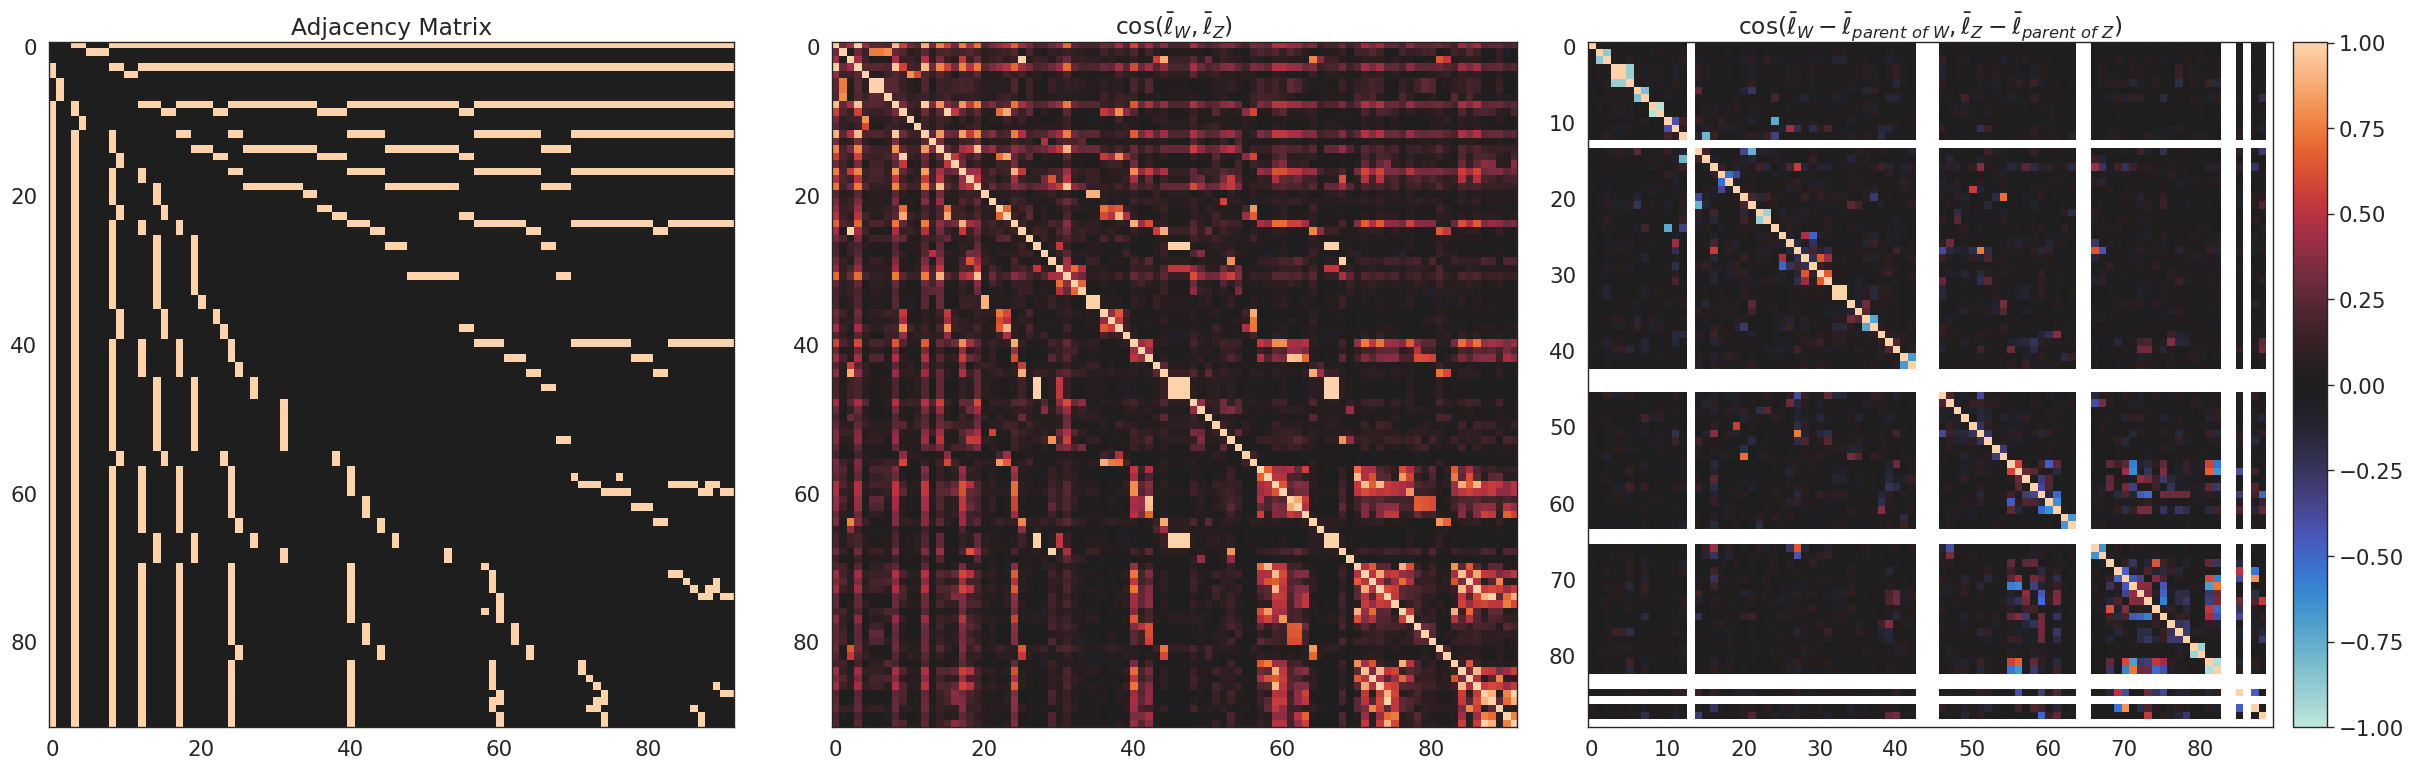

In [5]:
tc_G = nx.algorithms.dag.transitive_closure(G)
adj_mat = nx.adjacency_matrix(tc_G, nodelist=sorted_keys).todense()
adj_mat = adj_mat + adj_mat.T

lda_dirs = torch.stack([v['lda'] for k, v in dirs.items()])
lda_dirs = lda_dirs / lda_dirs.norm(dim = 1).unsqueeze(1)

for k, v in dirs.items():
       print(k)


child_parent = {}

print(sorted_keys)

for node in list(messed_up.keys()):
     sorted_keys.remove(node)
     print(node)

for node in sorted_keys:
        if len(list(G.predecessors(node))) > 0:
                parent = list(G.predecessors(node))[0]         #direct parent
                # print("node: "+ node)
                # print("parent: "+ parent)
                # print()
                # print(list(G.predecessors(node)))
                if parent not in list(messed_up.keys()):
                        # print(dirs[node]['lda'])
                        if [*dirs[node]['lda']] == [*dirs[parent]['lda']]:
                               print(f"equal: {node}, {parent}")
                        child_parent.update({node:  dirs[node]['lda'] - dirs[parent]['lda']})
        else:
               print("reject: " + node)         #throws out 3
                
lda_diff = torch.stack([lda_dirs[0]] + [v for k, v in child_parent.items()])    #adds back 1: 100 - 3 + 1 = 98


print("norms: " + str(lda_diff.norm(dim = 1)))
for thign in lda_diff:
       print(thign)
lda_diff = lda_diff / lda_diff.norm(dim = 1).unsqueeze(1)


hi = (lda_diff @ lda_diff.T).cpu().numpy()



# multiplying by transpose to get cosine similarity
# num_concepts x embedding_dim * embedding_dim x num_concepts = num_concepts x num_concepts
mats = [adj_mat,
        (lda_dirs @ lda_dirs.T).cpu().numpy(),
        hi]

titles = ["Adjacency Matrix",
          rf'$\cos(\bar{{\ell}}_{{W}}, \bar{{\ell}}_{{Z}})$',
          rf'$\cos(\bar{{\ell}}_{{W}} - \bar{{\ell}}_{{parent \,\, of \,\, W}}, \bar{{\ell}}_{{Z}} - \bar{{\ell}}_{{parent \,\, of \,\,Z}})$']
 
hrc.cos_heatmap(mats, titles, figsize = (25, 8),
                use_absvals=False,
                save_as = "noun_single_three_heatmap")

# print(mats[2][8])

In [6]:
for mat in mats:
    print(mat.shape)

(92, 92)
(92, 92)
(90, 90)


In [7]:
mat = mats[1]
print(mat.shape)
mat[0][0] = 0

print(mat)
print(mat[0][0])

(92, 92)
[[ 0.00000000e+00  3.09080631e-01  4.33623552e-01 ...  2.76315272e-01
   1.88638121e-01  2.26107791e-01]
 [ 3.09080631e-01  1.00000000e+00  3.05726212e-02 ...  1.37279749e-01
  -6.46737069e-02 -2.29724031e-02]
 [ 4.33623552e-01  3.05726212e-02  1.00000000e+00 ...  1.19663104e-01
   2.07705963e-02 -9.78761353e-04]
 ...
 [ 2.76315272e-01  1.37279749e-01  1.19663104e-01 ...  9.99999762e-01
   8.38995427e-02  7.78271109e-02]
 [ 1.88638121e-01 -6.46737069e-02  2.07705963e-02 ...  8.38995427e-02
   1.00000000e+00  7.73634732e-01]
 [ 2.26107791e-01 -2.29724031e-02 -9.78761353e-04 ...  7.78271109e-02
   7.73634732e-01  1.00000000e+00]]
0.0


In [ ]:
from networkx.drawing.nx_agraph import graphviz_layout
start_node = 'animal.n.01'
sub_G =nx.bfs_tree(G, start_node)
sub_G =  nx.DiGraph(G.subgraph(sub_G.nodes()))

pos = graphviz_layout(sub_G, prog='dot')
labels = {node: node.split('.', 1)[0] for node in sub_G.nodes()}

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
nx.draw_networkx_nodes(sub_G, pos, node_size=500, node_color='lightblue', alpha=0.2)
nx.draw_networkx_edges(sub_G, pos, edge_color='gray', width=2)
nx.draw_networkx_labels(sub_G, pos, labels=labels)

plt.axis('off')
plt.savefig(f"figures/sub_graph_tree.pdf", bbox_inches='tight')
plt.show()

NetworkXError: The node animal.n.01 is not in the digraph.

In [ ]:
sub_sorted_keys = list(nx.topological_sort(sub_G))
tc_G = nx.algorithms.dag.transitive_closure(G.subgraph(sub_sorted_keys))
adj_mat = nx.adjacency_matrix(tc_G, nodelist = sub_sorted_keys).todense()
adj_mat = adj_mat + adj_mat.T

lda_dirs = torch.stack([dirs[node]['lda'] for node in sub_sorted_keys])
lda_dirs = lda_dirs / lda_dirs.norm(dim = 1).unsqueeze(1)

child_parent = {}

for node in sub_sorted_keys:
    if len(list(sub_G.predecessors(node))) > 0:
        parent = list(sub_G.predecessors(node))[0]
        child_parent.update({node: dirs[node]['lda'] - dirs[parent]['lda']})
    
lda_diff = torch.stack([lda_dirs[0]] + [v for k, v in child_parent.items()])
lda_diff = lda_diff / lda_diff.norm(dim = 1).unsqueeze(1)

mats = [adj_mat,
        (lda_dirs @ lda_dirs.T).cpu().numpy(),
        (lda_diff @ lda_diff.T).cpu().numpy()]

titles = ["Adjacency Matrix",
          rf'$\cos(\bar{{\ell}}_{{W}}, \bar{{\ell}}_{{Z}})$',
          rf'$\cos(\bar{{\ell}}_{{W}} - \bar{{\ell}}_{{parent \,\, of \,\, W}}, \bar{{\ell}}_{{Z}} - \bar{{\ell}}_{{parent \,\, of \,\,Z}})$']

hrc.cos_heatmap(mats, titles, figsize = (27, 8),
                labels = [node.split('.', 1)[0] for node in sub_sorted_keys],
                use_absvals=False,
                save_as = "sub_noun_single_three_heatmap")

: 